In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
url = 'E:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

In [23]:
df = pd.read_csv(url, sep = ',')

In [24]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [25]:
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')
#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]

In [26]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,228.69,36.60,1,False,False,True,False,False,False,True,False,False
1,51676,0,61.0,0,0,1,0,202.21,30.19,1,False,False,False,True,False,False,False,True,False
2,31112,1,80.0,0,1,1,0,105.92,32.50,1,False,False,True,False,False,False,False,True,False
3,60182,0,49.0,0,0,1,1,171.23,34.40,1,False,False,True,False,False,False,False,False,True
4,1665,0,79.0,1,0,1,0,174.12,24.00,1,False,False,False,True,False,False,False,True,False


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


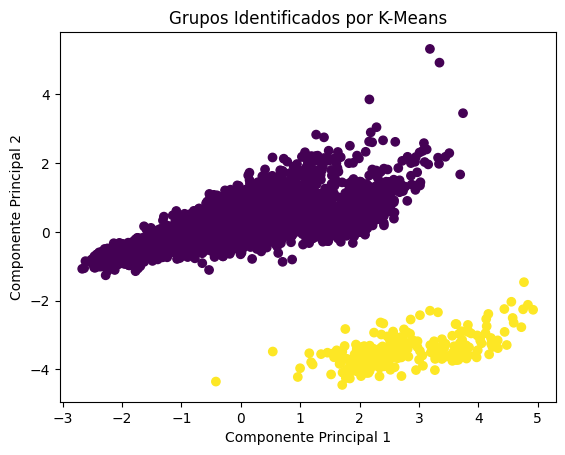

In [27]:
# Seleccionar las características para el análisis de clustering
X = df[['age', 'avg_glucose_level', 'bmi', 'stroke']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['cluster'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


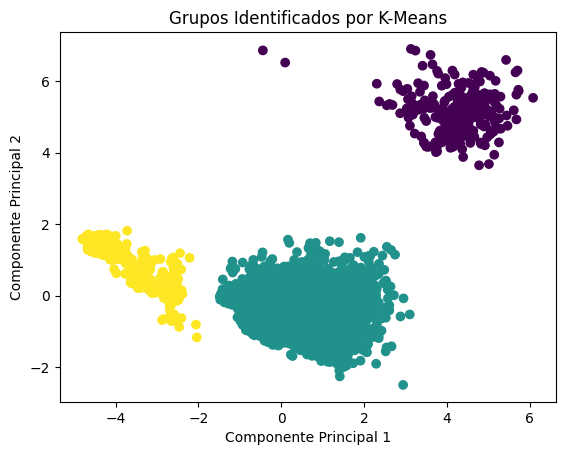

In [30]:
#Seleccionar las características para el análisis de clustering
X = df

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=16)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['cluster2'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


In [31]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster,cluster2
0,9046,1,67.0,0,1,1,1,228.69,36.60,1,...,False,True,False,False,False,True,False,False,1,0
1,51676,0,61.0,0,0,1,0,202.21,30.19,1,...,False,False,True,False,False,False,True,False,1,0
2,31112,1,80.0,0,1,1,0,105.92,32.50,1,...,False,True,False,False,False,False,True,False,1,0
3,60182,0,49.0,0,0,1,1,171.23,34.40,1,...,False,True,False,False,False,False,False,True,1,0
4,1665,0,79.0,1,0,1,0,174.12,24.00,1,...,False,False,True,False,False,False,True,False,1,0


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

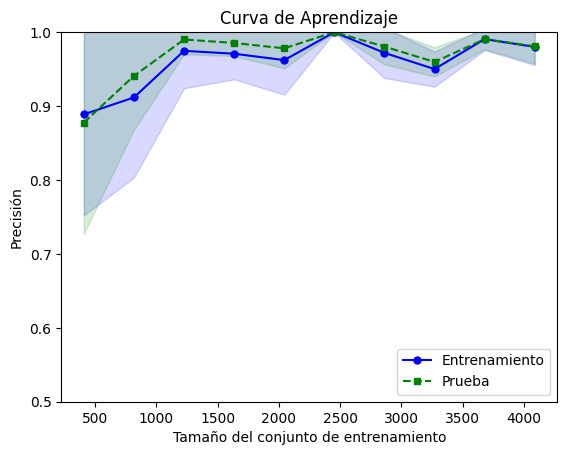

Precisión en datos de entrenamiento: 1.0
Precisión en datos de prueba: 0.9990215264187867


In [32]:
# Seleccionar las características y la variable objetivo para df
X = df.drop(columns = "stroke")
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Crear el modelo de regresión logística
reg = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
reg.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de entrenamiento y prueba
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calcular la precisión para los datos de entrenamiento y prueba
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(reg, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

print("Precisión en datos de entrenamiento:", train_acc)
print("Precisión en datos de prueba:", test_acc)

In [33]:
# Calcular el F1-score para los datos de entrenamiento y prueba
train_f1 = f1_score(y_train, train_pred)
test_f1 = f1_score(y_test, test_pred)

print("F1-score en datos de entrenamiento:", train_f1)
print("F1-score en datos de prueba:", test_f1)

F1-score en datos de entrenamiento: 1.0
F1-score en datos de prueba: 0.9896907216494846


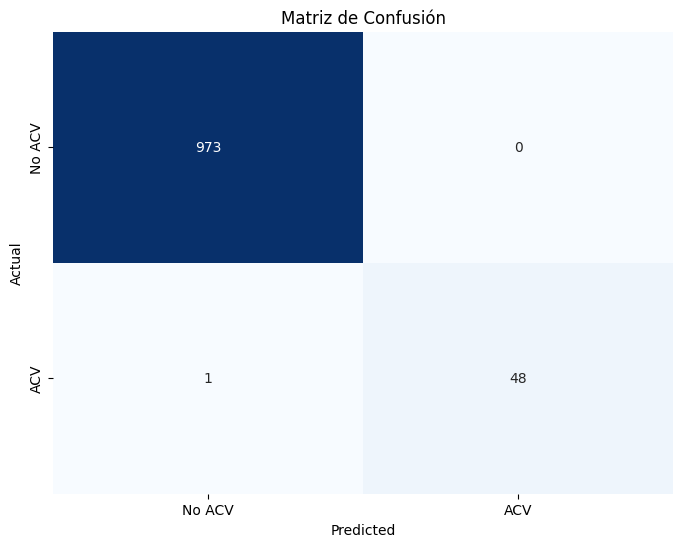

In [34]:
# Obtener las predicciones del modelo para los datos de prueba
y_pred = reg.predict(X_test)

# Crear la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.yticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.show()

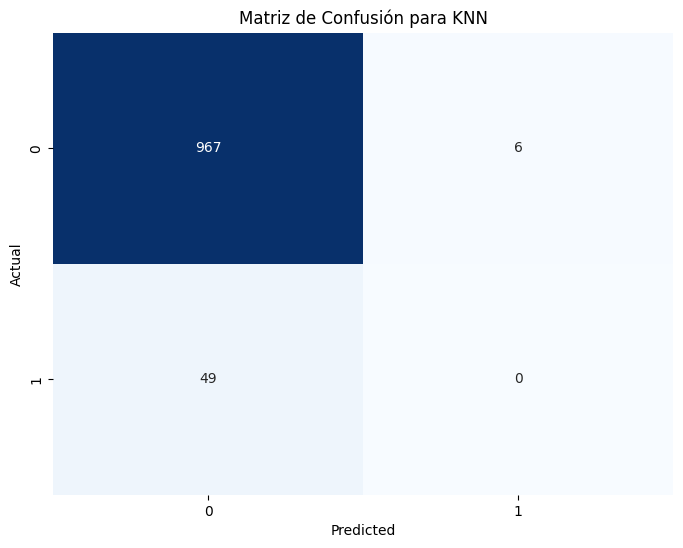

Precisión de KNN en datos de prueba: 0.9461839530332681


In [35]:
# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)

# Entrenar el modelo con los datos de entrenamiento
knn_model.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de prueba
knn_test_pred = knn_model.predict(X_test)

# Calcular la precisión para los datos de prueba
knn_test_acc = accuracy_score(y_test, knn_test_pred)
# Crear la matriz de confusión para KNN
cm_knn = confusion_matrix(y_test, knn_test_pred)

# Crear el heatmap de la matriz de confusión para KNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión para KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Precisión de KNN en datos de prueba:", knn_test_acc)


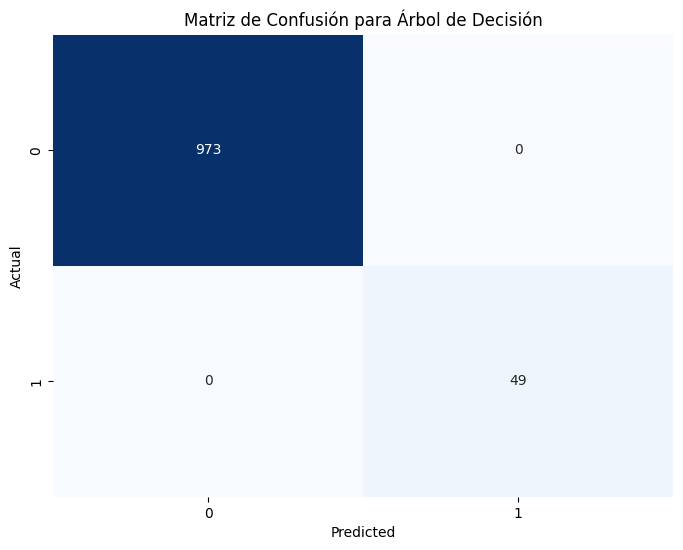

Precisión del Árbol de Decisión en datos de prueba: 1.0


In [36]:
# Crear el modelo de Árbol de Decisión
tree_model = DecisionTreeClassifier(max_depth=3)

# Entrenar el modelo con los datos de entrenamiento
tree_model.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de prueba
tree_test_pred = tree_model.predict(X_test)

# Calcular la precisión para los datos de prueba
tree_test_acc = accuracy_score(y_test, tree_test_pred)
# Crear la matriz de confusión para Árbol de Decisión
cm_tree = confusion_matrix(y_test, tree_test_pred)

# Crear el heatmap de la matriz de confusión para Árbol de Decisión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Precisión del Árbol de Decisión en datos de prueba:", tree_test_acc)

Epoch 1/50
103/103 - 1s - loss: 0.3722 - accuracy: 0.9443 - val_loss: 0.2552 - val_accuracy: 0.9413 - 561ms/epoch - 5ms/step
Epoch 2/50
103/103 - 0s - loss: 0.1596 - accuracy: 0.9535 - val_loss: 0.1180 - val_accuracy: 0.9413 - 97ms/epoch - 942us/step
Epoch 3/50
103/103 - 0s - loss: 0.0693 - accuracy: 0.9627 - val_loss: 0.0563 - val_accuracy: 0.9731 - 87ms/epoch - 840us/step
Epoch 4/50
103/103 - 0s - loss: 0.0370 - accuracy: 0.9927 - val_loss: 0.0322 - val_accuracy: 0.9988 - 91ms/epoch - 884us/step
Epoch 5/50
103/103 - 0s - loss: 0.0204 - accuracy: 0.9991 - val_loss: 0.0165 - val_accuracy: 1.0000 - 87ms/epoch - 849us/step
Epoch 6/50
103/103 - 0s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000 - 89ms/epoch - 864us/step
Epoch 7/50
103/103 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000 - 90ms/epoch - 874us/step
Epoch 8/50
103/103 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 - 89ms/epoch - 864u

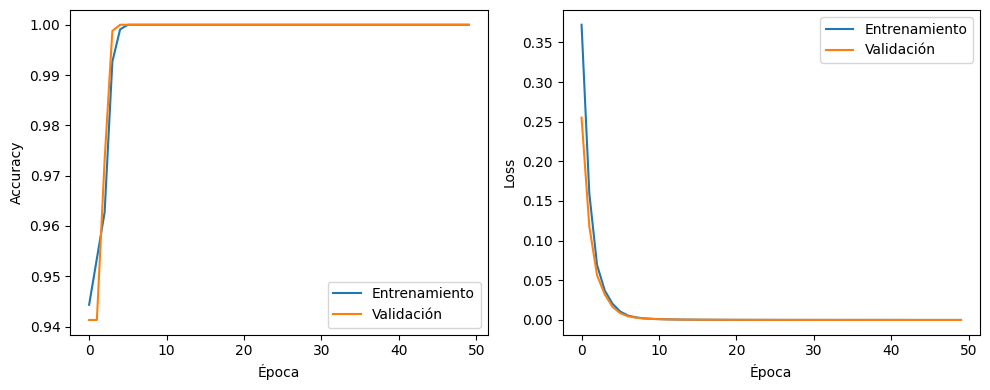

32/32 [==============================] - 0s 474us/step


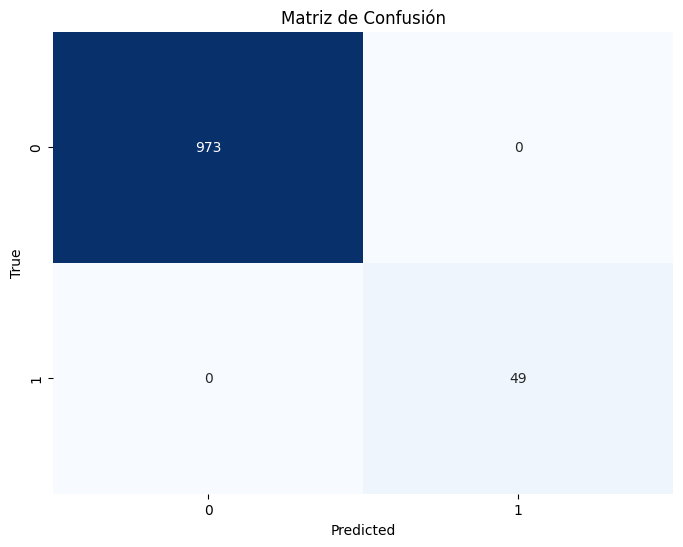

In [41]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo y guardar el historial de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Graficar el aprendizaje (accuracy y loss)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en los datos de prueba
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()
